# MLP Models

Ok so let's bring out the big guns and try on the simple dataset

In [1]:
%pip install tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow import keras
import pickle, os, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
sys.path.append("..")
from utils import plot_mat_comp, flatten_triang, unflatten_triang, flatten_triang_batch, unflatten_triang_batch, perform_calculation, density_from_fock, reverse_mat_permutation

Test and train data is generated in overlap_to_fock_first_steps and also used here!

In [4]:
with open('models/test_data.pkl', 'rb') as f:
    test = pickle.load(f)
with open('models/train_data.pkl', 'rb') as f:
    train = pickle.load(f)
train_X = np.array([overlap for _, overlap, _, _ in train])
train_y = np.array([fock for fock, _, _, _ in train])
test_X = np.array([overlap for _, overlap, _, _ in test])
test_y = np.array([fock for fock, _, _, _ in test])
train_files = np.array([file for _, _, file, _ in train])
test_files = np.array([file for _, _, file, _ in test])
train_densities = np.array([density for _, _, _, density in train])
test_densities = np.array([density for _, _, _, density in test])
mat_dim = train_X[0].shape[0]
mat_dim


ValueError: too many values to unpack (expected 4)

# Data Aug

In [4]:
def data_aug(train_X, train_y, test_X, test_y, train_files, test_files,  multiple=5): 
    from scf_guess_tools import load, Backend
    train_X_aug, train_y_aug = [], []
    test_X_aug, test_y_aug = [], []
    nr_atoms = int(open(train_files[0]).readlines()[0].split()[0]) # assume same number of atoms in all files
    for X, y, file in zip(train_X,  train_y,  train_files):
        mol = load(file, Backend.PY).native
        ao = mol.ao_labels()
        train_X_aug.append(X) # original
        train_y_aug.append(y) # original
        for _ in range(1, multiple): 
            # augment with random permutation
            perm = np.random.permutation(nr_atoms)
            train_X_aug.append(reverse_mat_permutation(X, ao, perm))
            train_y_aug.append(reverse_mat_permutation(y, ao, perm))

    for X, y, file in zip(test_X,  test_y,  test_files):
        mol = load(file, Backend.PY).native
        ao = mol.ao_labels()
        test_X_aug.append(X) # original
        test_y_aug.append(y) # original
        for _ in range(1, multiple): 
            # augment with random permutation
            perm = np.random.permutation(nr_atoms)
            test_X_aug.append(reverse_mat_permutation(X, ao, perm))
            test_y_aug.append(reverse_mat_permutation(y, ao, perm))
    train_X_aug = np.array(train_X_aug)
    train_y_aug = np.array(train_y_aug)
    test_X_aug = np.array(test_X_aug)
    test_y_aug = np.array(test_y_aug)
     
    return train_X_aug, train_y_aug, test_X_aug, test_y_aug

In [5]:
data_Aug = True
if data_Aug: 
    print("Data Augmentation")
    train_X, train_y, test_X, test_y = data_aug(train_X, train_y, test_X, test_y, train_files, test_files)

Data Augmentation


In [6]:
def summary(X): 
    print(f"shape: {X.shape}")
    print(f"dtype: {X.dtype}")
    print(f"min: {np.min(X)}")
    print(f"max: {np.max(X)}")
    print(f"mean: {np.mean(X)}")
    print(f"std: {np.std(X)}")
    print(f"median: {np.median(X)}")
    print(f"10th percentile: {np.percentile(X, 10)}")
    print(f"90th percentile: {np.percentile(X, 90)}")

In [7]:
train_X_flattened = flatten_triang_batch(train_X)
train_y_flattened = flatten_triang_batch(train_y)
test_X_flattened = flatten_triang_batch(test_X)
test_y_flattened = flatten_triang_batch(test_y)
summary(train_X_flattened)

shape: (2030, 1225)
dtype: float64
min: -0.4781431157238504
max: 1.0000000000000002
mean: 0.04801266638789595
std: 0.2105067425676543
median: 5.214819106295551e-07
10th percentile: -0.022566803988282633
90th percentile: 0.10159268928878581


In [8]:
# scale data
scalerX = StandardScaler()
scalerY = StandardScaler()
train_X_scaled_flattened = scalerX.fit_transform(train_X_flattened)
train_y_scaled_flattened = scalerY.fit_transform(train_y_flattened)
test_X_scaled_flattened = scalerX.transform(test_X_flattened)
test_y_scaled_flattened = scalerY.transform(test_y_flattened)

summary(train_X_scaled_flattened)

shape: (2030, 1225)
dtype: float64
min: -29.253090340070862
max: 43.363883306346594
mean: 3.5144970945407586e-18
std: 0.9797958971132713
median: -0.054512637057200254
10th percentile: -0.4837577825435838
90th percentile: 0.505664317081799


Now we only take upper triangular matrix!

In [9]:
# for now set a seed
tf.random.set_seed(42)

flattened_dim = train_X_scaled_flattened.shape[1]
inputs = tf.keras.Input(shape=(flattened_dim,))
x = tf.keras.layers.Dense(512, activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.35)(x)
outputs = tf.keras.layers.Dense(flattened_dim)(x)

basic_model = tf.keras.Model(inputs=inputs, outputs=outputs)
basic_model.compile(optimizer='adam', loss="mae", metrics=["mse", 'mae'])
# basic_model.summary()


2025-04-14 13:40:35.420705: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6837 - mae: 0.6837 - mse: 1.2247 - val_loss: 0.5344 - val_mae: 0.5344 - val_mse: 1.0502
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5262 - mae: 0.5262 - mse: 1.0271 - val_loss: 0.4875 - val_mae: 0.4875 - val_mse: 1.0187
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4680 - mae: 0.4680 - mse: 0.9844 - val_loss: 0.4670 - val_mae: 0.4670 - val_mse: 1.0092
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4521 - mae: 0.4521 - mse: 0.9805 - val_loss: 0.4470 - val_mae: 0.4470 - val_mse: 0.9893
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4429 - mae: 0.4429 - mse: 0.9796 - val_loss: 0.4343 - val_mae: 0.4343 - val_mse: 0.9810
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4359 - mae: 0.4359 - mse: 0.9792 - val_loss: 0.4292 - val_mae: 0.4292 - val_mse: 0.9764
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4323 - mae: 0.4323 - mse: 0.9755 - val_loss: 

Text(0.5, 1.0, 'Model loss')

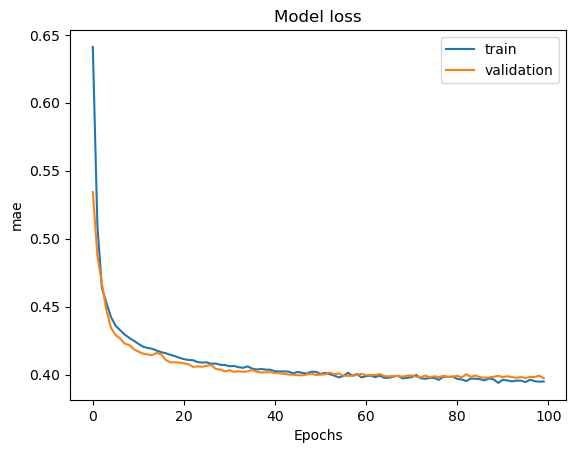

In [10]:
basic_history = basic_model.fit(train_X_scaled_flattened, train_y_scaled_flattened, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
plt.plot(basic_history.history['loss'], label='train')
plt.plot(basic_history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.title('Model loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


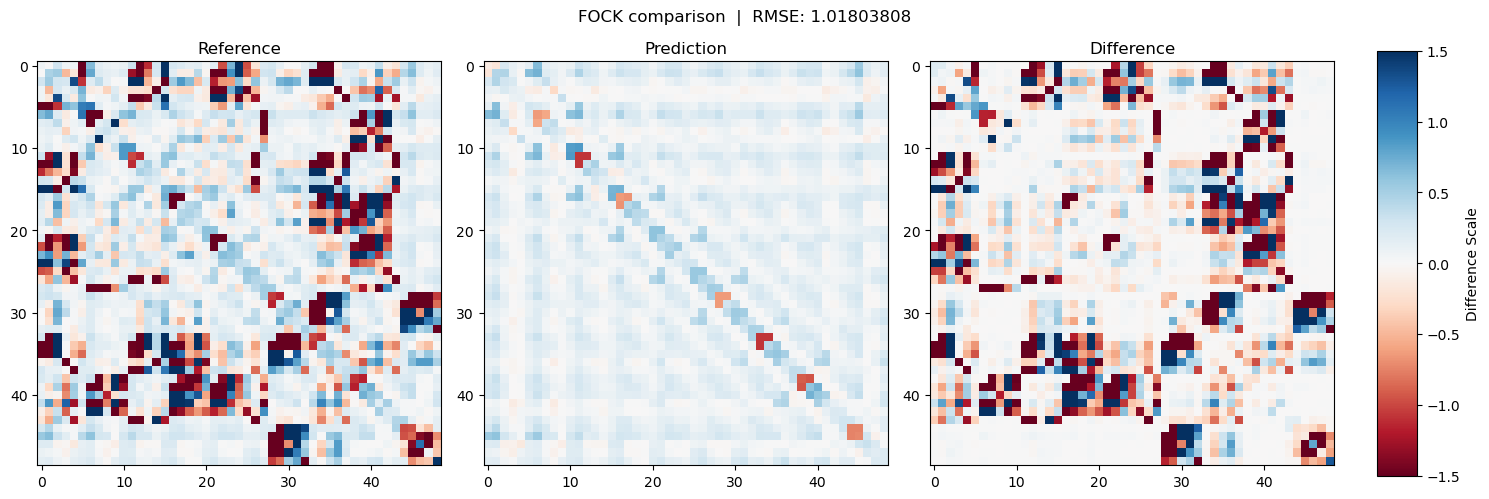

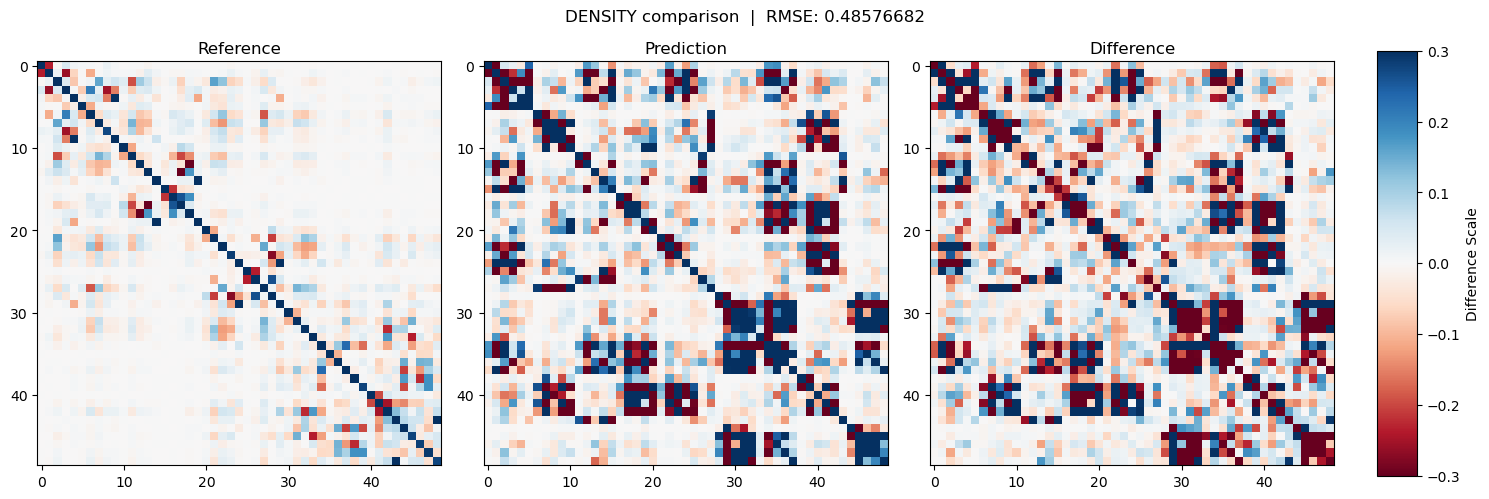

converged SCF energy = -446.829019699
{'cycles': 24, 'conv': True, 'summary': {'nuc': np.float64(394.08914668298803), 'e1': np.float64(-1390.203970269086), 'coul': np.float64(608.8304775299389), 'exc': np.float64(-59.54467364284098)}, 'wf': <pyscf.dft.rks.RKS object at 0x7eff386be0d0>, 'mol': <pyscf.gto.mole.Mole object at 0x7eff919cb350>}


In [11]:
def random_sample(model = basic_model, flat_input=True):
    random_test_sample = np.random.randint(0, len(test_X_scaled_flattened))
    test_file = test_files[random_test_sample]
    test_ref = test_y_scaled_flattened[random_test_sample]
    if flat_input:
        test_pred = model.predict(test_X_scaled_flattened[random_test_sample].reshape(1, -1))
    else: 
        sample = unflatten_triang(test_X_scaled_flattened[random_test_sample], mat_dim) 
        test_pred = model.predict(sample.reshape(1, mat_dim, mat_dim))
    plot_mat_comp(test_ref, test_pred[0], reshape=49, title="FOCK comparison")
    # rescale prediciton
    test_pred_rescaled = scalerY.inverse_transform(test_pred.reshape(1, -1)).reshape(-1)
    test_pred_rescaled = unflatten_triang(test_pred_rescaled, 49)
    density_prediction = density_from_fock(test_pred_rescaled, test_X[random_test_sample], 32)
    plot_mat_comp(test_densities[random_test_sample], density_prediction, title="DENSITY comparison", vmax=0.3)
    summary = perform_calculation(test_file, 2*density_prediction, "sto-3g", "dft", "b3lypg")
    print(summary)

random_sample()


In [12]:
flattened_dim = train_X_scaled_flattened.shape[1]
inputs = tf.keras.Input(shape=(flattened_dim,))
x = tf.keras.layers.Dense(512, activation='gelu')(inputs)
for _ in range(4):
    x = tf.keras.layers.Dense(512, activation='gelu')(x)
# x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(256, activation='gelu')(x)
x = tf.keras.layers.Dropout(0.35)(x)
outputs = tf.keras.layers.Dense(flattened_dim)(x)

basic_model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)
basic_model_2.compile(optimizer='adam', loss="mae", metrics=["mse", 'mae'])

Epoch 1/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.4733 - mae: 0.4733 - mse: 1.0080 - val_loss: 0.4381 - val_mae: 0.4381 - val_mse: 1.0142
Epoch 2/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4420 - mae: 0.4420 - mse: 1.0037 - val_loss: 0.4302 - val_mae: 0.4302 - val_mse: 0.9984
Epoch 3/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4359 - mae: 0.4359 - mse: 0.9934 - val_loss: 0.4277 - val_mae: 0.4277 - val_mse: 0.9932
Epoch 4/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4320 - mae: 0.4320 - mse: 0.9882 - val_loss: 0.4269 - val_mae: 0.4269 - val_mse: 0.9898
Epoch 5/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4305 - mae: 0.4305 - mse: 0.9847 - val_loss: 0.4249 - val_mae: 0.4249 - val_mse: 0.9860
Epoch 6/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4288 - mae: 0.4288 - mse: 0.9802 - val_loss: 0.4233 - val_mae: 0.4233 - val_mse: 0.9799
Epoch 7/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4269 - mae: 0.4269 - mse: 0.9756 - val_los

Text(0.5, 1.0, 'Model loss')

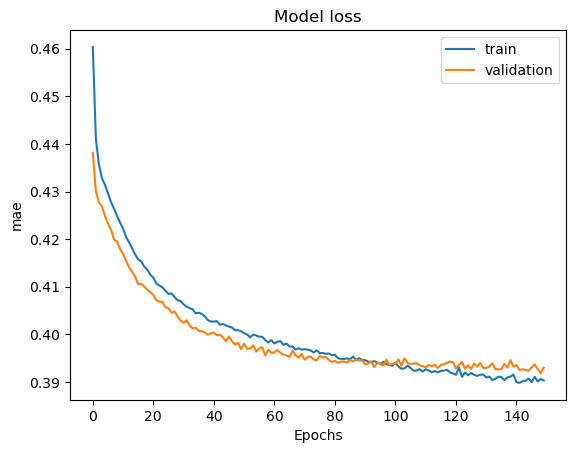

In [13]:
basic_history_2 = basic_model_2.fit(train_X_scaled_flattened, train_y_scaled_flattened, epochs=150, batch_size=32, validation_split=0.2, verbose=1)
plt.plot(basic_history_2.history['loss'], label='train')
plt.plot(basic_history_2.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.title('Model loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


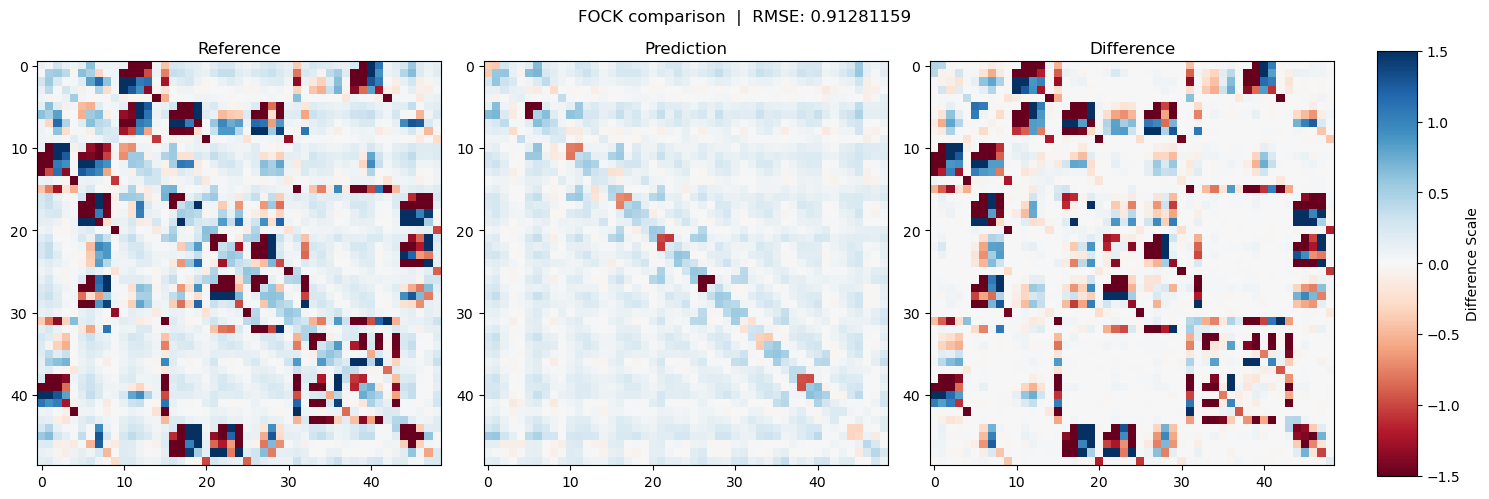

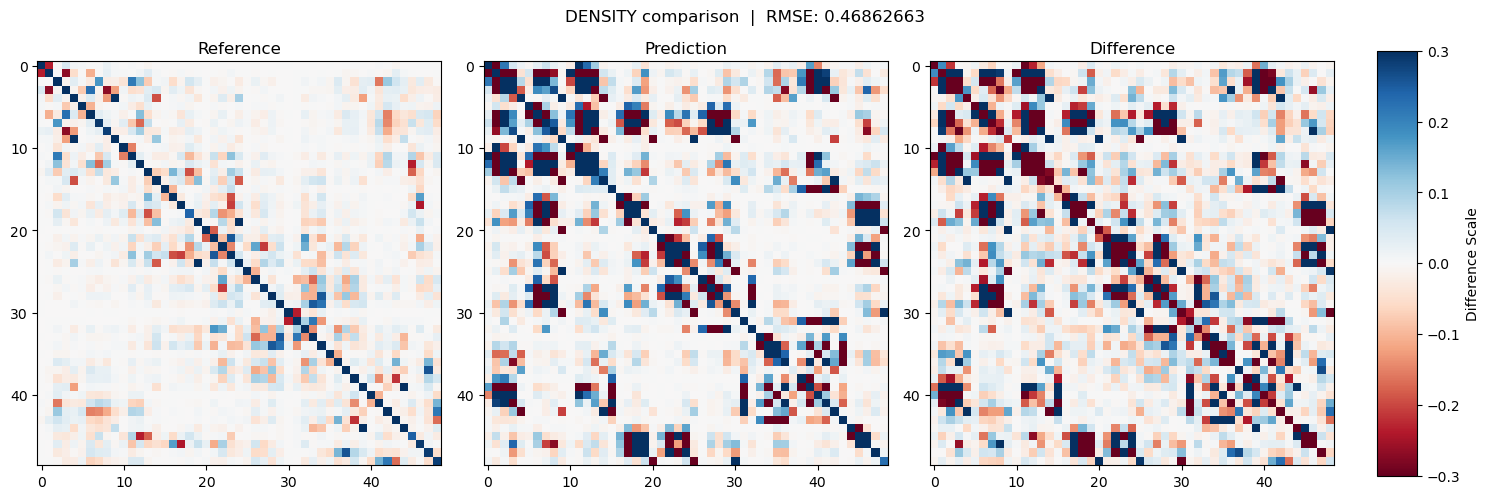

converged SCF energy = -446.88295070821
{'cycles': 23, 'conv': True, 'summary': {'nuc': np.float64(413.12828149023755), 'e1': np.float64(-1429.2438795983962), 'coul': np.float64(628.872313800268), 'exc': np.float64(-59.639666400319314)}, 'wf': <pyscf.dft.rks.RKS object at 0x7eff181b85d0>, 'mol': <pyscf.gto.mole.Mole object at 0x7efef8765390>}


In [14]:
random_sample(basic_model_2)

# CNN 
Anscheinend kommt das MLP nicht gerade weit oder ich mach keine schönen Architekturen

In [15]:
# unflattened versions
flattened_sol_dim = train_y_scaled_flattened.shape[1]
train_X_scaled = unflatten_triang_batch(train_X_scaled_flattened, mat_dim)
test_X_scaled = unflatten_triang_batch(test_X_scaled_flattened, mat_dim)

# train_y_scaled = unflatten_triang_batch(train_y_scaled_flattened, mat_dim)
# test_y_scaled = unflatten_triang_batch(test_y_scaled_flattened, mat_dim)

In [16]:
tf.random.set_seed(42)
from tensorflow.keras import layers, Model, Input
dropout_rate = 0.5

inputs = Input(shape=(mat_dim, mat_dim, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(flattened_sol_dim)(x)

cnn_m1 = tf.keras.Model(inputs=inputs, outputs=outputs)

cnn_m1.compile(optimizer='adam', loss="mae", metrics=["mse", 'mae'])
cnn_m1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 49, 49, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 49, 49, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1225)           │       314,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,210,505 (8.43 MB)

 Trainable params: 2,210,505 (8.43 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
cnn_m1_history = cnn_m1.fit(train_X_scaled, train_y_scaled_flattened, epochs=1000, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.4862 - mae: 0.4862 - mse: 1.0073 - val_loss: 0.4469 - val_mae: 0.4469 - val_mse: 1.0196
Epoch 2/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4497 - mae: 0.4497 - mse: 1.0227 - val_loss: 0.4413 - val_mae: 0.4413 - val_mse: 1.0308
Epoch 3/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4458 - mae: 0.4458 - mse: 1.0279 - val_loss: 0.4412 - val_mae: 0.4412 - val_mse: 1.0318
Epoch 4/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4445 - mae: 0.4445 - mse: 1.0295 - val_loss: 0.4410 - val_mae: 0.4410 - val_mse: 1.0325
Epoch 5/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4438 - mae: 0.4438 - mse: 1.0303 - val_loss: 0.4405 - val_mae: 0.4405 - val_mse: 1.0340
Epoch 6/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4433 - mae: 0.4433 - mse: 1.0311 - val_loss: 0.4404 - val_mae: 0.4404 - val_mse: 1.0345
Epoch 7/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4430 - mae: 0.4430 - mse: 1.031

Text(0.5, 1.0, 'Model loss')

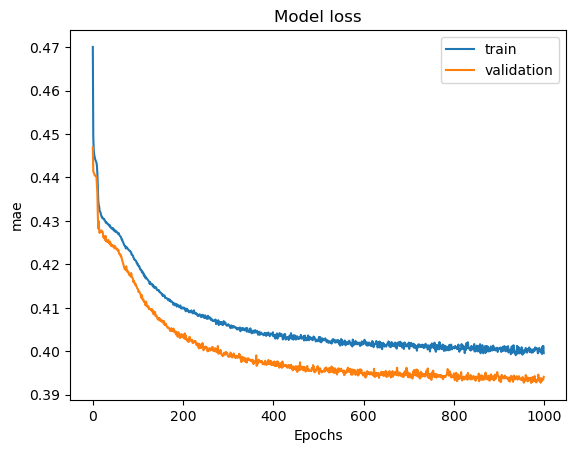

In [18]:
plt.plot(cnn_m1_history.history['loss'], label='train')
plt.plot(cnn_m1_history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.title('Model loss')

In [19]:
random_sample(cnn_m1, flat_input=False)

IndexError: index 315 is out of bounds for axis 0 with size 102